In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '20'
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy as sp
import matplotlib.pyplot as plt
import libpysal as lps
import random
from matplotlib import rcParams
import seaborn as sns

sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)
rcParams["savefig.bbox"] = "tight"

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


#### Load data

In [2]:
anndat_multiome = ad.read_h5ad('../data/10XMultiome/10XPBMC.CD4T.pseudo.h5ad')

####  Implement the core function to calculate Local L

In [3]:
import multiome.graph_measure as gm
anndat_multiome = gm.Morans_I(anndat_multiome)

Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
6.631s past


In [4]:
anndat_multiome = gm.Local_L(anndat_multiome,
                             I_cutoff=0.4,
                             pct_cutoff=0.05,
                             dropout_rm=True)


Filtering features by Moran's I and feature sparsity in single-cell data...
Previously calculated Moran's I found.
Keep features with Moran's I > 0.4 and at least 5.0% expressed in single-cell data...
1331 pairs left for graph-based correlation L calculation.

Calculating local graph-based correlation value...
Set L to 0 for cells with no expression on either feature of a certain pair...
Following changes made to the AnnData object:
	Graph-based Pearson Correlation results saved in uns['Local_L']
	uns['peaks_nearby']['Local_L'] added indicates feature selected for local L calculation or not.


#### Subclustering and tracjectory analysis

Extracting [obs x G-P defined region] matrix...
Define coarse groups of the cluster for partition-based graph abstraction (PAGA)...


/mnt/atlas_local/chaozhong/data/thesis/multiome/pair_analysis.py:79: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndat_L = ad.AnnData(


7 clusters found. Try tuning leiden_resol to get different numbers.
Generate the PAGA for determining the root for trajectory analysis...
Please select the root cluster and run the code again with root = cluster number chosen.


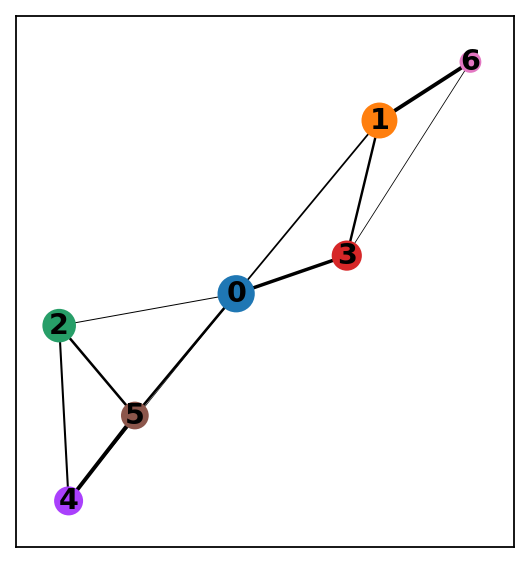


Following changes made to the AnnData object:
	Sub-cluster labels	obs['leiden'] as category dtype.


In [5]:
import multiome.pair_analysis as pa
anndat_multiome = pa.RegulatoryAnalysis(anndat_multiome, binary=False,
                                        weighted=False, leiden_resol=0.15)

In [6]:
anndat_multiome = pa.RegulatoryAnalysis(anndat_multiome, binary=False, root='1',
                                        weighted=False, leiden_resol=0.15)

Extracting [obs x G-P defined region] matrix...
Define coarse groups of the cluster for partition-based graph abstraction (PAGA)...


/mnt/atlas_local/chaozhong/data/thesis/multiome/pair_analysis.py:79: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndat_L = ad.AnnData(


7 clusters found. Try tuning leiden_resol to get different numbers.
Generate the PAGA for determining the root for trajectory analysis...

Following changes made to the AnnData object:
	Sub-cluster labels	obs['leiden'] as category dtype.
	Trajectory pseudotime	obs['dpt_pseudotime'] as numerical values.


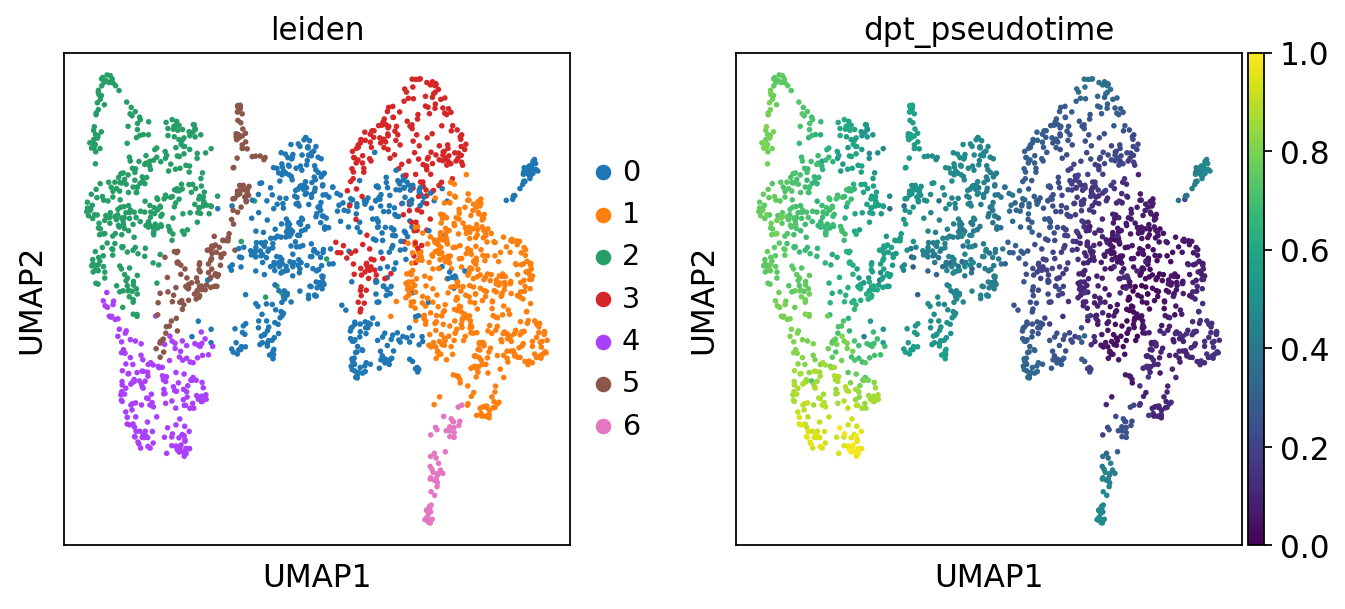

In [7]:
sc.pl.umap(anndat_multiome, size=25, color=['leiden','dpt_pseudotime'])

#### Results back to single-cell data

In [8]:
import multiome.data_preparation as dp
anndat_mod1 = ad.read_h5ad('data/PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('data/PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('data/PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)

seurat_wnn = pd.read_csv('data/seurat_wnn_graph.csv',header=None, index_col=0)
nn_map = dp.nn_map_Seurat(seurat_wnn, K = 20)

anndat_mod1, anndat_mod2, nn_map = dp.subset(anndat_mod1, anndat_mod2, nn_map,
                                             by='seurat_annotations',
                                             groups = ['CD4 Naive','CD4 TCM','CD4 TEM'])

In [9]:
anndat_mod1 = dp.map_back_sc(anndat_mod1, anndat_multiome,
                                           label='dpt_pseudotime', embed='X_umap')
anndat_mod1 = dp.map_back_sc(anndat_mod1, anndat_multiome,
                                           label='leiden', embed='X_umap')


Mapping back from mini-bulk to single-cell data...

Compensating missing cells by its 5 neighbors in X_umap...


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/pandas/core/indexing.py:1628: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value



Following infos added to the AnnData:
	dpt_pseudotime labels	obs['dpt_pseudotime']
Mapping back from mini-bulk to single-cell data...

Compensating missing cells by its 5 neighbors in X_umap...

Following infos added to the AnnData:
	leiden labels	obs['leiden']
	leiden label probability matrix	obsm['leiden_prob']


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


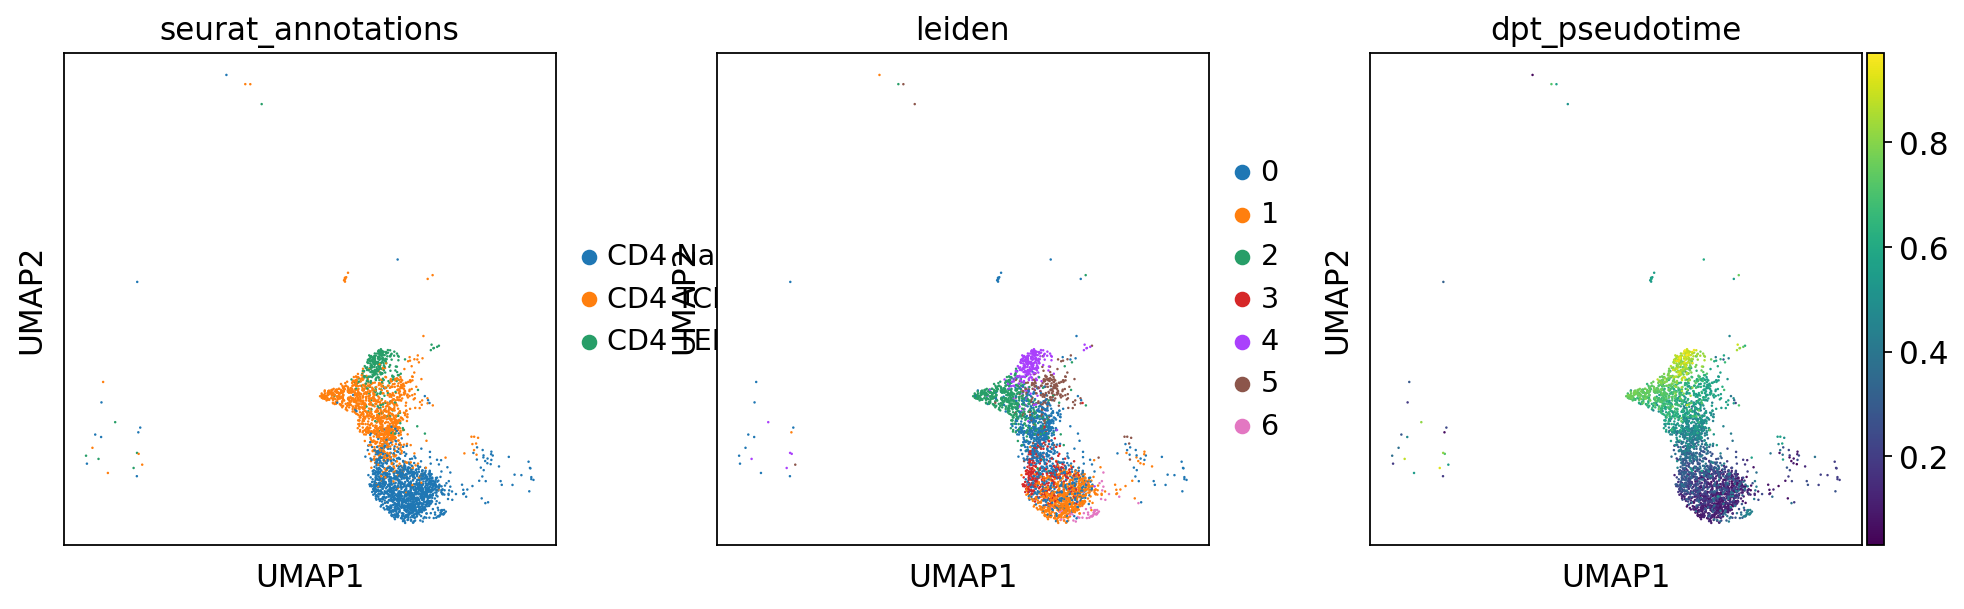

In [10]:
sc.pl.umap(anndat_mod1, size=5, color=['seurat_annotations','leiden','dpt_pseudotime'])


#### Feature Module Discovery

In [11]:
import multiome.functional_anno as functional_anno
features = [gp.split('_')[0] for gp in anndat_multiome.uns['Local_L_names']]
anndat_mod1 = functional_anno.Time_Module(anndat_mod1, features,
                                          bins=25,
                                          pseudotime_label='dpt_pseudotime',
                                          som_shape=(3,3))

Generating pseudotime feature matrix for self-organizing map construction...
Start training...
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 2.8542032349058704
No module name given, will use integer 1 as name
Module index saved in var['Module_index_1']
Mappings of winner nodes saved in uns['win_map_1']


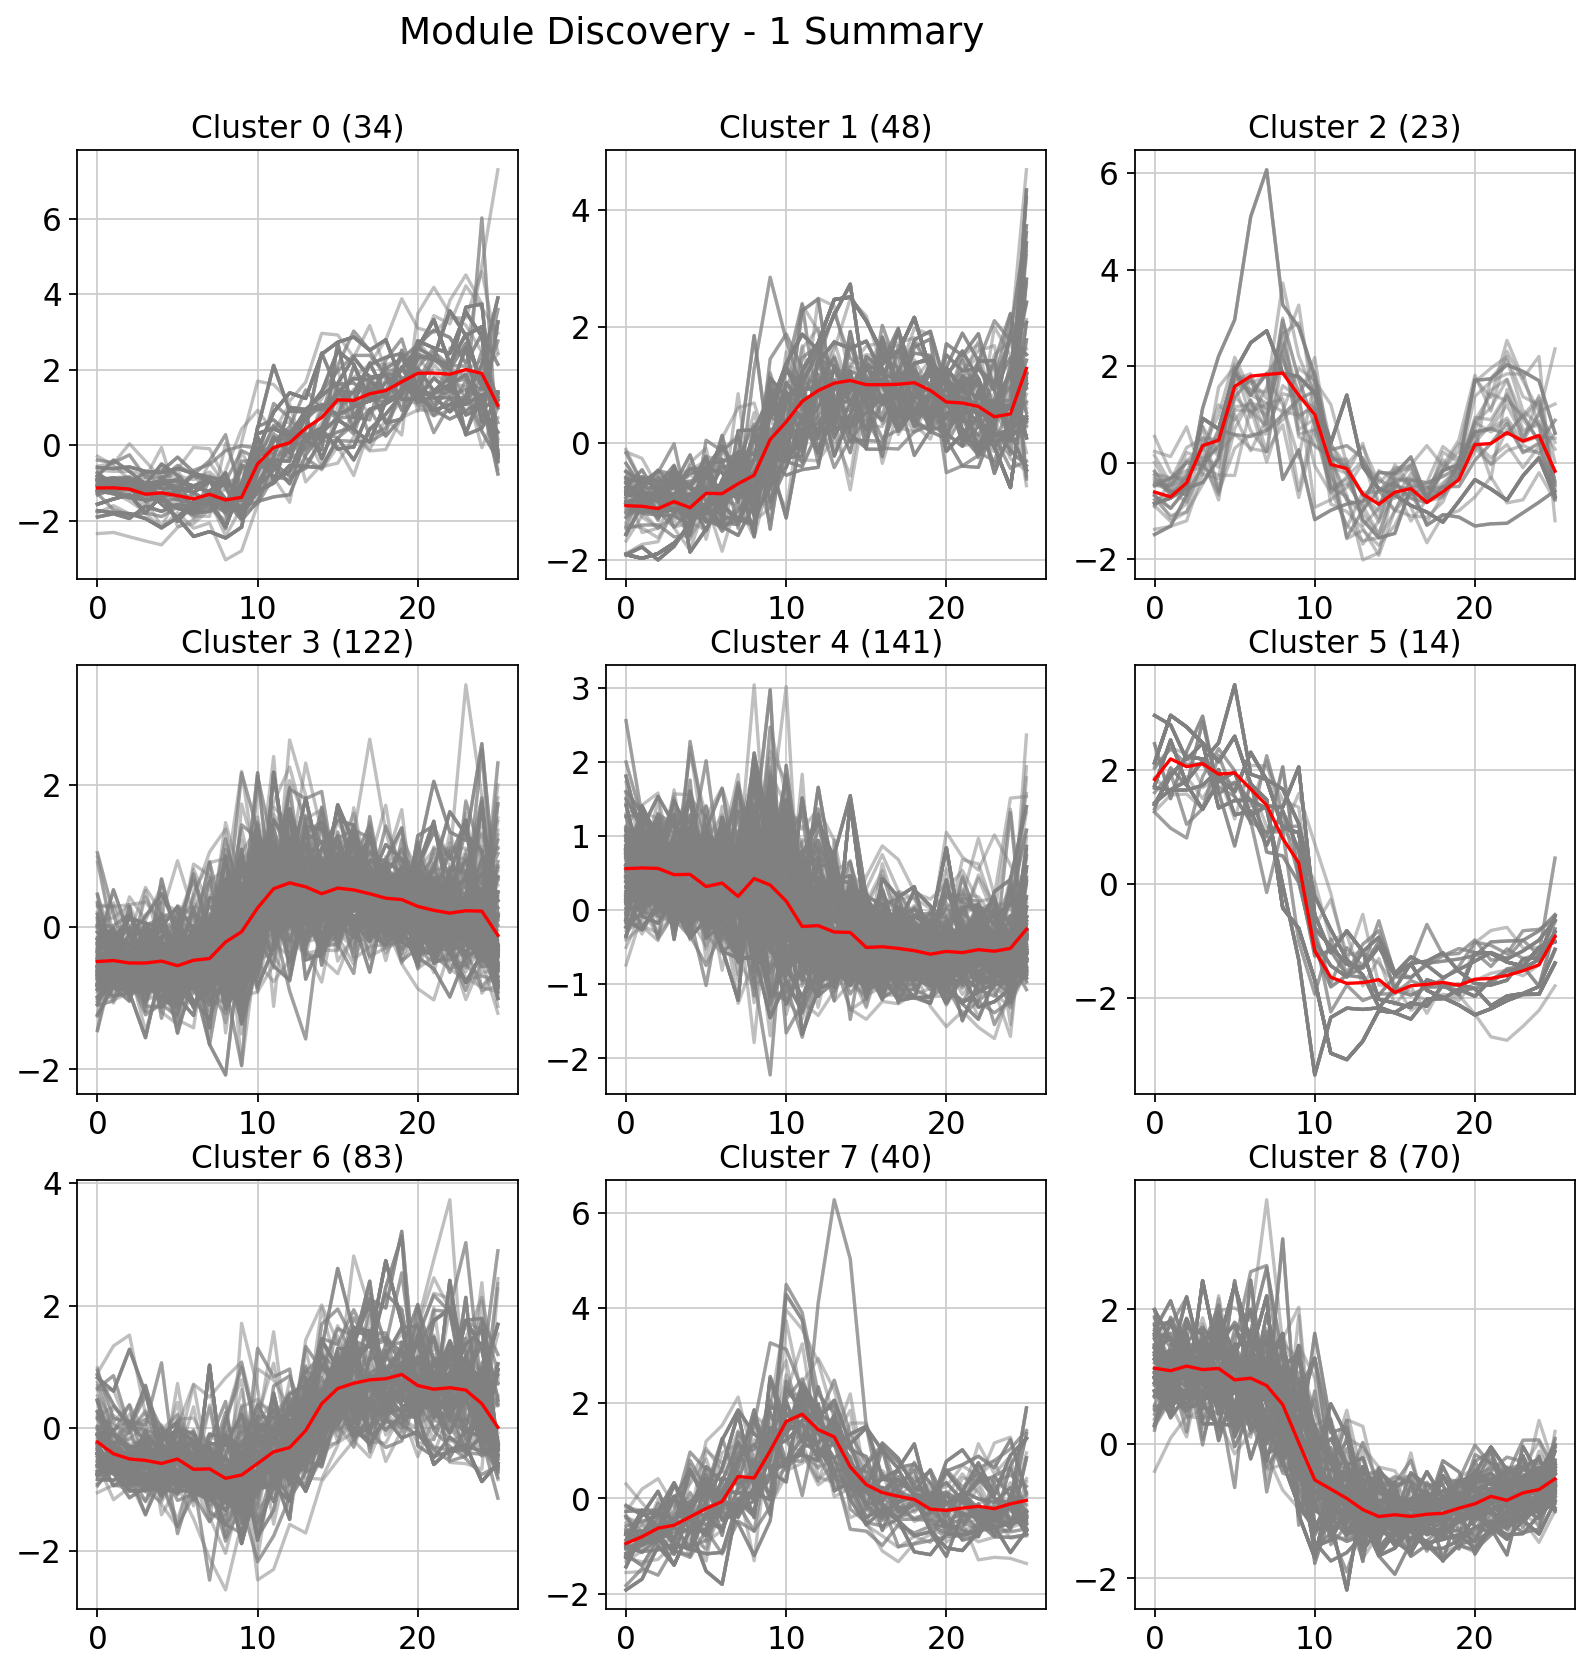

In [12]:
f = functional_anno.visualize_module(anndat_mod1, '1', figsize=(12,12), save='figure3C.pdf')

In [13]:
# Save gene list
genes = anndat_mod1.var_names[anndat_mod1.var['Module_index_1'].isin([5,8])]
pd.DataFrame(genes).to_csv('10X_CD4T.SOM_5n8.txt',index=False,header=False)

#### What if use scRNA-seq data for trajectory analysis?

In [14]:
# single-cell data preprocessing
anndat_sc = ad.read_h5ad('../data/10XMultiome/PBMC_10X_GEX.h5ad')
anndat_sc.X = anndat_sc.layers['counts'].copy()
sc.pp.normalize_total(anndat_sc)
sc.pp.log1p(anndat_sc)

anndat_sc = anndat_sc[anndat_sc.obs['seurat_annotations'].isin(['CD4 Naive','CD4 TCM','CD4 TEM'])]

sc.pp.highly_variable_genes(anndat_sc)
anndat_sc.raw = anndat_sc

anndat_sc = anndat_sc[:, anndat_sc.var.highly_variable]
sc.pp.scale(anndat_sc, max_value=10)

sc.tl.pca(anndat_sc, svd_solver='randomized', use_highly_variable=False)
sc.pp.neighbors(anndat_sc, n_neighbors=20, n_pcs=30)
sc.tl.leiden(anndat_sc, resolution=0.5)
sc.tl.umap(anndat_sc)


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


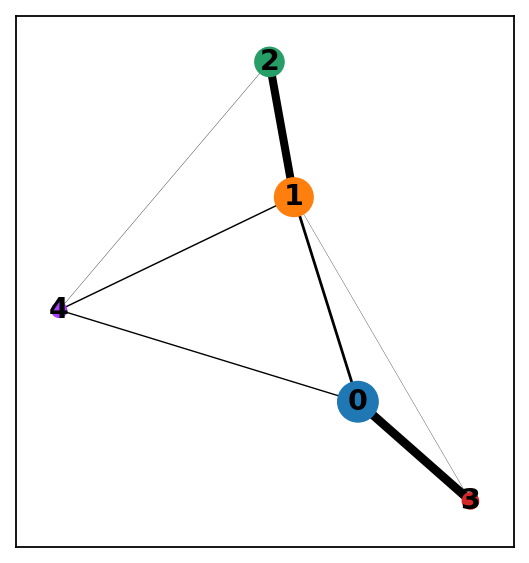

In [15]:
sc.tl.paga(anndat_sc, groups='leiden')
sc.pl.paga(anndat_sc, color=['leiden'])

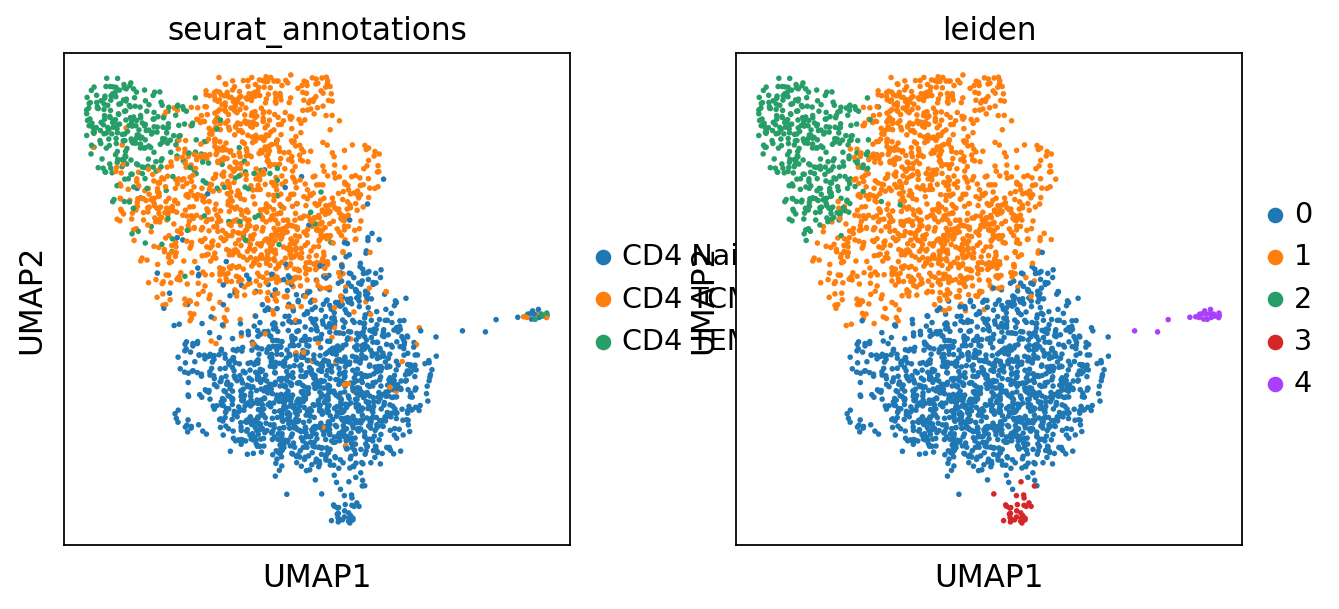

In [16]:
sc.pl.umap(anndat_sc, size=25, color=['seurat_annotations','leiden'])

In [17]:
anndat_sc = anndat_sc[anndat_sc.obs['leiden'].isin(['0','1','2'])]

In [18]:
anndat_sc.uns['iroot'] = np.flatnonzero(anndat_sc.obs['leiden']  == str('0'))[0]
sc.tl.dpt(anndat_sc)

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [19]:
anndat_mod1.obs['pseudotime_rna'] = anndat_sc.obs['dpt_pseudotime'].copy()
anndat_mod1.obs['pseudotime_reg'] = anndat_mod1.obs['dpt_pseudotime'].copy()

In [20]:
anndat_sc.obs['pseudotime_reg'] = anndat_mod1.obs['dpt_pseudotime']
anndat_sc.obs['pseudotime_rna'] = anndat_sc.obs['dpt_pseudotime'].copy()
anndat_sc.obs['cluster_reg'] = anndat_mod1.obs['leiden'].copy()


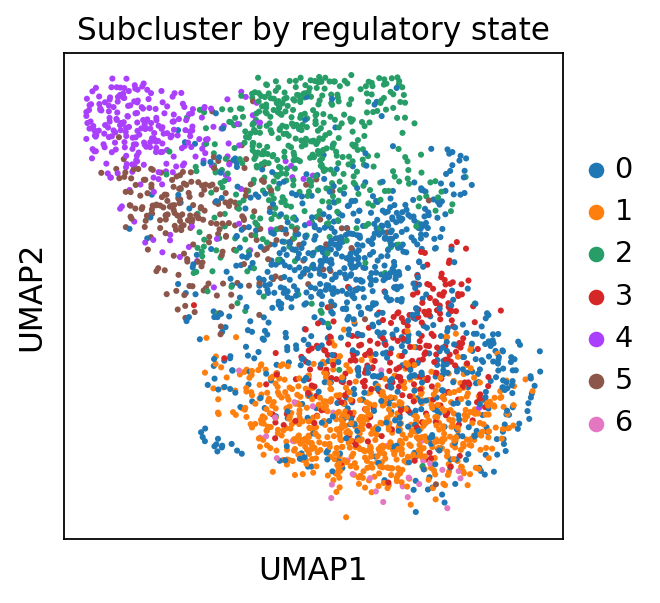

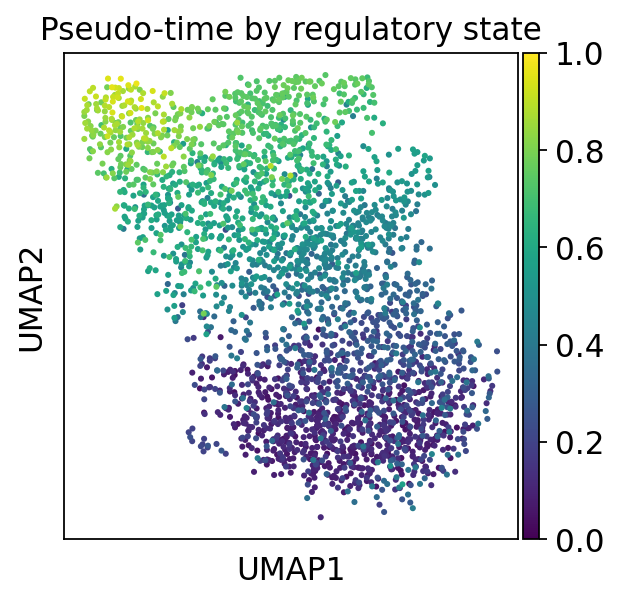

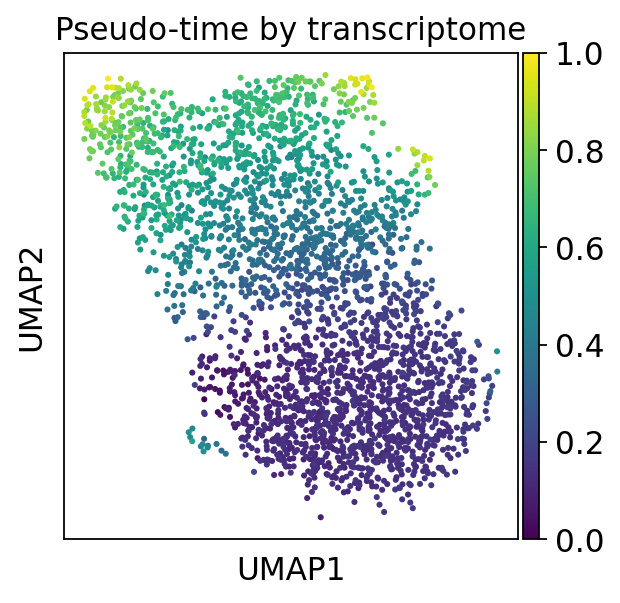

In [23]:
f = sc.pl.umap(anndat_sc, size=30, color=['cluster_reg'],
               title='Subcluster by regulatory state',
               return_fig=True)
f.savefig('figure3A1.pdf',dpi=300)

f = sc.pl.umap(anndat_sc, size=30, color=['pseudotime_reg'],
               vmin=0, vmax=1.0,
               title='Pseudo-time by regulatory state',
               return_fig=True)
f.savefig('figure3A2.pdf',dpi=300)

f = sc.pl.umap(anndat_sc, size=30, color=['pseudotime_rna'],
               vmin=0, vmax=1.0,
               title='Pseudo-time by transcriptome',
               return_fig=True)
f.savefig('figure3A3.pdf',dpi=300)

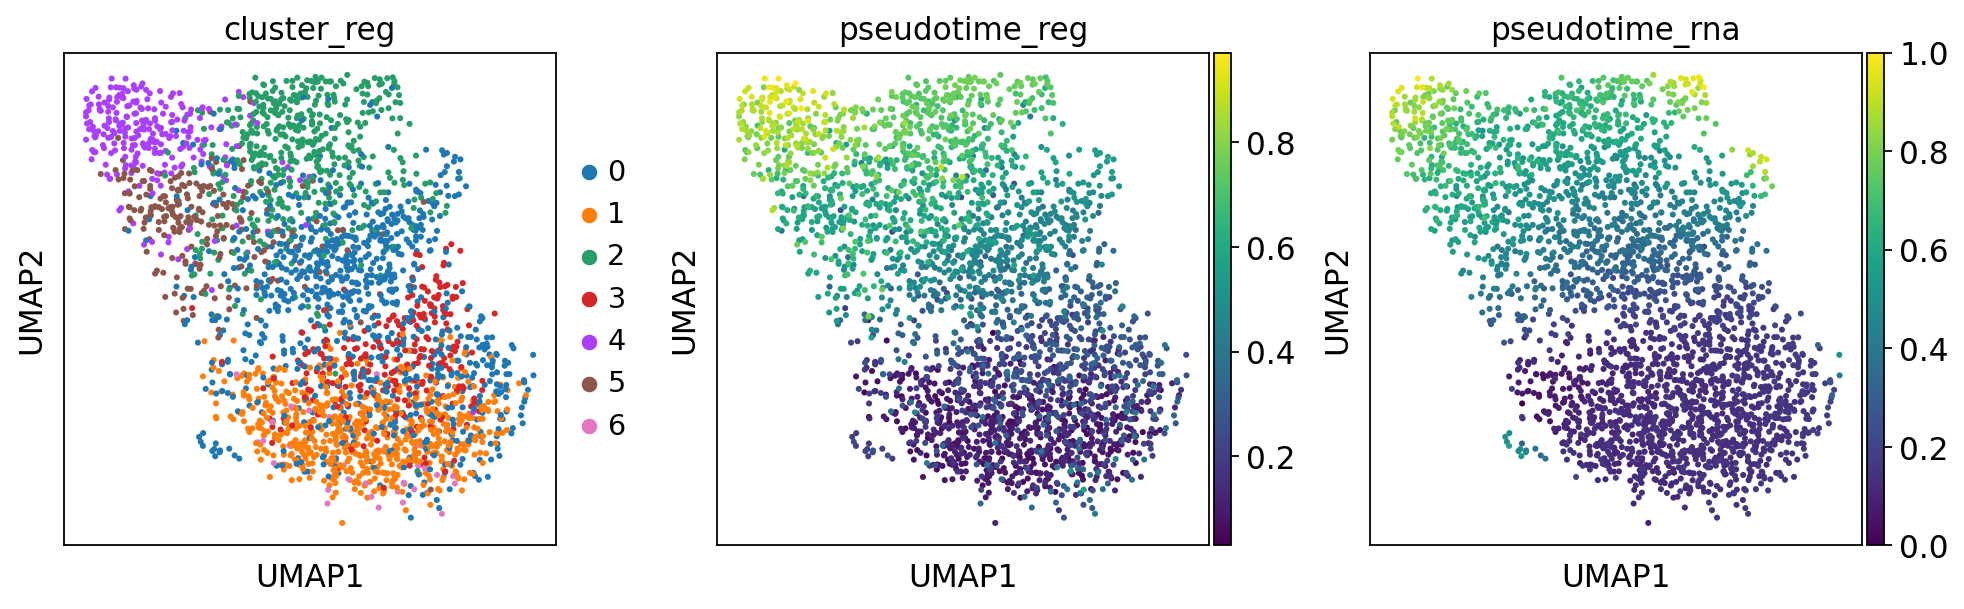

In [21]:
sc.pl.umap(anndat_sc, size=30, color=['cluster_reg','pseudotime_reg','pseudotime_rna'],
           #cmap='bwr',
           vmin=[None,None,0.0,0.0], vmax=[None,None,1.0,1.0])


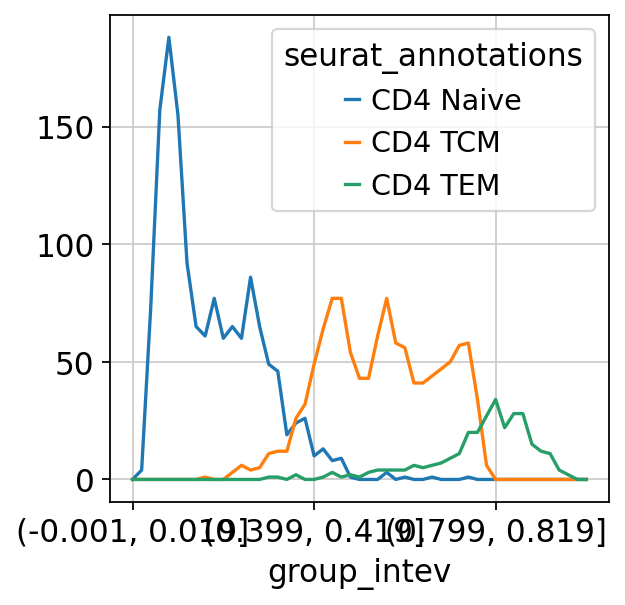

In [22]:
ct_mtx = anndat_mod1.obs[['seurat_annotations','pseudotime_reg']].copy()
ct_mtx.to_csv('10X_CD4T.timecurve.reg.raw.csv',index=False)
ct_mtx = ct_mtx.sort_values(by='pseudotime_reg')
time_range = (0, 1)
N_interval = 50
interv_range = (time_range[1] - time_range[0]) / N_interval

group_intev = pd.cut(ct_mtx['pseudotime_reg'], np.arange(time_range[0]-1e-3, 
                                      time_range[1]+interv_range,
                                      interv_range))
ct_mtx['group_intev'] = group_intev
data = ct_mtx.groupby(['seurat_annotations','group_intev']).size().sort_index()
data.unstack().T.plot.line()
data = pd.DataFrame(data)
data.columns = ['n_cells']
data['ptime'] = [i.right for i in data.index.get_level_values('group_intev')]
data['cell_type'] = data.index.get_level_values('seurat_annotations')
data.to_csv('10X_CD4T.timecurve.reg.bin.csv',index=False)

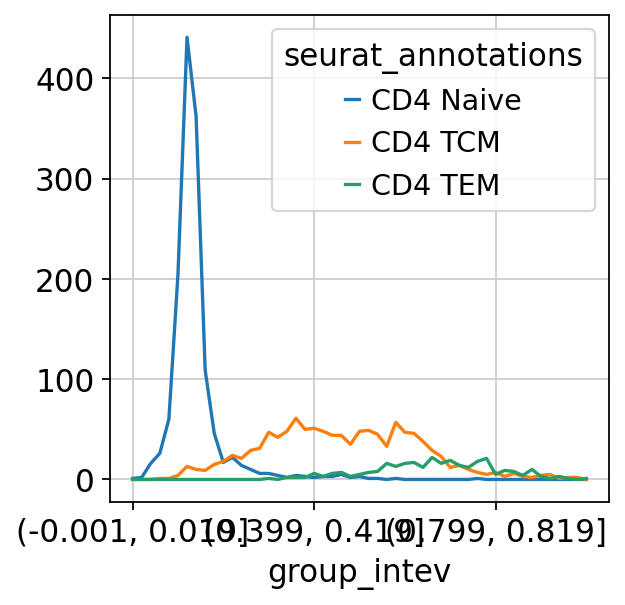

In [23]:
ct_mtx = anndat_mod1.obs[['seurat_annotations','pseudotime_rna']].copy()
ct_mtx.to_csv('10X_CD4T.timecurve.rna.raw.csv',index=False)

ct_mtx = ct_mtx.sort_values(by='pseudotime_rna')
time_range = (0, 1)
N_interval = 50
interv_range = (time_range[1] - time_range[0]) / N_interval

group_intev = pd.cut(ct_mtx['pseudotime_rna'], np.arange(time_range[0]-1e-3, 
                                      time_range[1]+interv_range,
                                      interv_range))
ct_mtx['group_intev'] = group_intev
data = ct_mtx.groupby(['seurat_annotations','group_intev']).size().sort_index()
data.unstack().T.plot.line()
data = pd.DataFrame(data)
data.columns = ['n_cells']
data['ptime'] = [i.right for i in data.index.get_level_values('group_intev')]
data['cell_type'] = data.index.get_level_values('seurat_annotations')
data.to_csv('10X_CD4T.timecurve.rna.csv',index=False)

### Homer

In [24]:
genes = pd.read_csv('10X_CD4T.SOM_5n8.txt',header=None)[0].to_numpy()
pairs = pd.DataFrame(anndat_multiome.uns['Local_L_names'],columns=['names'])
pairs['genes'] = pairs['names'].str.split('_').str[0]
pairs['peaks'] = pairs['names'].str.split('_').str[1]
peaks = pairs.loc[pairs['genes'].isin(genes),'peaks'].to_numpy()
peaks = np.unique(peaks)

In [25]:
len(peaks)

265

In [26]:
import multiome.functional_anno as functional_anno

homer_df = functional_anno.run_HOMER_motif(peaks, out_dir='homer/',
                                           prefix='CD4Ttraj', ref_genome='hg38',
                                           homer_path='/mnt/atlas_local/chaozhong/data/homer/',
                                           split_symbol=['-','-'], size=200)

Save peaks list in BED file format at homer/CD4Ttraj.peaks.bed
Creat HOMER output folder at homer/homer_CD4Ttraj



	Position file = homer/CD4Ttraj.peaks.bed
	Genome = hg38
	Output Directory = homer/homer_CD4Ttraj
	Fragment size set to 200
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 265
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 265
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.

	Extracting sequences from file: /mnt/atlas_local/chaozhong/data/homer/.//data/genomes/hg38///genome.fa
	Looking for peak sequences in a single file (/mnt/atlas_local/chaozhong/data/homer/.//data/genomes/hg38///genome.fa)
	Extracting 28 sequences from chr1
	Extracting 13 sequences from chr10
	Extracting 8 sequences from chr11
	Extracting 11 sequences from chr12
	Extracting 2 seq

		=Final=: -20.66 KCTRWCAG T:96.0(36.23%),B:9766.0(20.17%),P:1e-8
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: CGACACCT... (-10.821)
		Round 1: -11.11 CGACACCT T:7.0(2.61%),B:94.8(0.19%),P:1e-4
		Round 2: -11.26 CGACACAT T:8.0(2.98%),B:138.1(0.28%),P:1e-4
		Round 3: -13.80 CGACMCAT T:17.0(6.23%),B:664.7(1.36%),P:1e-5
		Round 4: -16.12 CGACACAT T:15.0(5.51%),B:415.1(0.85%),P:1e-6
		Round 5: -16.12 CGACACAT T:15.0(5.51%),B:415.1(0.85%),P:1e-6
		=Final=: -16.18 CGACACAT T:14.0(5.28%),B:411.5(0.85%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: GTGTGTGT... (-10.632)
		Round 1: -16.71 GTGTGTGT T:170.0(47.41%),B:18214.6(31.36%),P:1e-7
		Round 2: -18.05 GTATGTGT T:212.0(55.14%),B:23196.8(38.07%),P:1e-7
		Round 3: -18.63 GTGTGTGT T:199.0(52.87%),B:21327.2(35.63%),P:1e-8
		Round 4: -18.91 GTGTGYGT T:202.0(53.41%),B:21490.2(35.85%),P:1e-8
		Round 5: -18.91 GTGTGYGT 

		Reprioritizing potential motifs...
	13 of 25 Initial Sequence: GGTTTCTCTT... (-9.117)
		Round 1: -16.94 GGTTTCTCTT T:21.0(7.63%),B:832.0(1.70%),P:1e-7
		Round 2: -16.94 GGTTTCTCTT T:21.0(7.63%),B:832.0(1.70%),P:1e-7
		=Final=: -16.07 GGTTTCTCTT T:16.0(6.04%),B:554.6(1.15%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: TGTCATTACC... (-9.117)
		Round 1: -19.62 TGTCATTACC T:12.0(4.44%),B:166.5(0.34%),P:1e-8
		Round 2: -19.62 TGTCATTACC T:12.0(4.44%),B:166.5(0.34%),P:1e-8
		=Final=: -22.26 TGTCATTACC T:12.0(4.53%),B:165.8(0.34%),P:1e-9
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	15 of 25 Initial Sequence: CTCTGTGGTT... (-8.508)
		Round 1: -19.79 CTCTGTGGTT T:47.0(16.28%),B:2970.3(5.95%),P:1e-8
		Round 2: -19.79 CTCTGTGGTT T:47.0(16.28%),B:2970.3(5.95%),P:1e-8
		=Final=: -19.69 CTCTGTGGTT T:43.0(16.23%),B:2890.5(5.97%),P:1e-8
		Performing exhaustive masking of motif...
		Reprioritiz

		Round 1: -21.27 ATGACAGTTACT T:5.0(1.87%),B:3.8(0.01%),P:1e-9
		Round 2: -21.27 ATGACAGTTACT T:5.0(1.87%),B:3.8(0.01%),P:1e-9
		=Final=: -25.38 ATGACAGTTACT T:5.0(1.89%),B:3.8(0.01%),P:1e-11
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: GCAAGGAGGAGG... (-8.502)
		Round 1: -16.49 GCAAGGAGGAGG T:6.0(2.24%),B:19.1(0.04%),P:1e-7
		Round 2: -17.72 ACACGGAGGAGG T:11.0(4.07%),B:155.1(0.32%),P:1e-7
		Round 3: -17.72 ACACGGAGGAGG T:11.0(4.07%),B:155.1(0.32%),P:1e-7
		=Final=: -17.90 ACACGGAGGAGG T:10.0(3.77%),B:151.3(0.31%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	Remaining seeds don't look promising (After initial 5 motifs, logp -8.354 > -8.423)

	Finalizing Enrichment Statistics (new in v3.4)
	Reading input files...
	50000 total sequences read
	Cache length = 11180
	Using binomial scoring
	Checking enrichment of 14 motif(s)
	|0%                                    50%               

sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlo

HOMER finished successfully! Please check the HTML report for interesting motifs.
motif_summary can be run with the motif index for further analysis.


sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
	Formatting HTML page...
		1 of 26 (1e-12) similar to MA0480.1_Foxo1/Jaspar(0.576)
		2 of 26 (1e-11) similar to PB0166.1_Sox12_2/Jaspar(0.577)
		3 of 26 (1e-11) similar to MA0100.2_Myb/Jaspar(0.735)
		4 of 26 (1e-10) similar to EWS:ERG-fusion(ETS)/CADO_ES1-EWS:ERG-ChIP-Seq(SRA014231)/Homer(0.816)
		5 of 26 (1e-10) similar to PB0190.1_Tcfap2b_2/Jaspar(0.573)
		6 of 26 (1e-10) similar to PB0126.1_Gata